In [282]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE] 

This code will take upper air RAOB observations and completes a stereographic map projection to complete a 500 mb analysis map and a contoured map of observation numbers with varying radii of curvature 

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [283]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles 
import pandas as pd


In [284]:
### Read in observations 
#Use Pandas to open ROAB file and seperate the CSV.  
fi = pd.read_csv('./RAOBs_201903131200.txt', names=['Station ID', 'Latitude', 'Longitude', '500 mb Height', "Wind Direction", "Wind Speed"])

#Make sure data is read in 
print(fi['500 mb Height']) 

0      5460.0
1      5540.0
2      5360.0
3      5340.0
4      5220.0
        ...  
130    5730.0
131    5620.0
132    5340.0
133    5580.0
134    5340.0
Name: 500 mb Height, Length: 135, dtype: float64


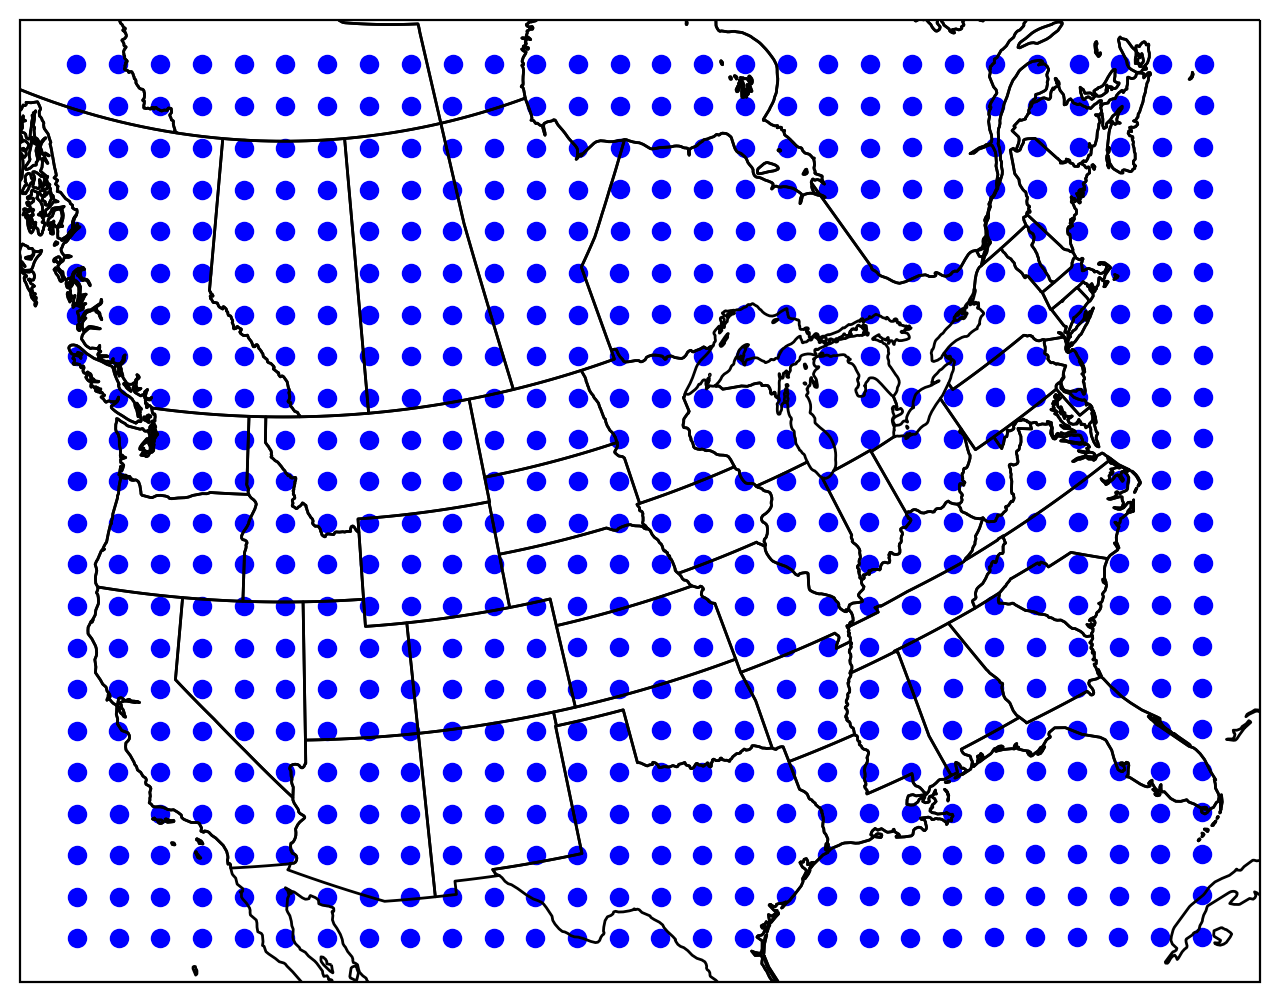

In [285]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x = 22 
y = 28

#Set up grid 
gridx = 18.9 + np.arange(x)*1.27                      
gridy = -6.3 + np.arange(y)*1.27                       

#Use np.meshgrid to create rectangular grid for map
gx, gy = np.meshgrid(gridx, gridy) 

#Check to see if np.meshgrid worked. 
#print(gx)

#Set Constants to calculate gridlon and gridlat to project 
phi_lat = 60 * (np.pi/180)
roe = 6371 * 1e5 
llambda = -115
scale = 1/(15e6)
rad = (180/np.pi)

#Complete Latitude and longitude grid (Be sure to add rad conversion)
gridlon = rad * np.arctan(gy/gx) + llambda
gridlat = rad * ((np.pi/2) - (2*np.arctan((np.sqrt((gx/scale)**2 + (gy/scale)**2))/(roe*(1+np.sin(phi_lat)))))) 

# plot grid to verify
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
plot1= fig.add_subplot(111,projection=proj)
plot1.add_feature(cfeature.STATES)
plot1.add_feature(cfeature.COASTLINE) 
plot1.scatter(gridlon.ravel(), gridlat.ravel(), c = 'blue', transform = ccrs.PlateCarree()) 




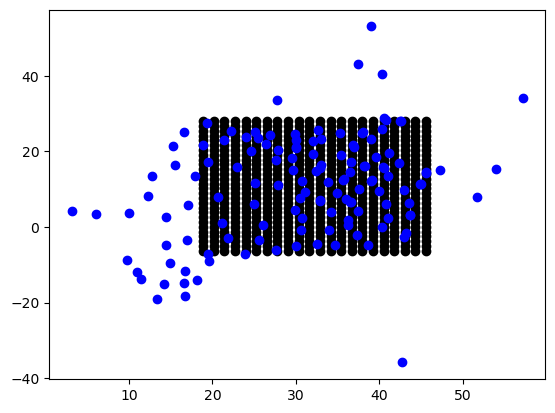

In [286]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
## Bring in Latitude and Longitude from RAOB file and convert
lat = fi['Latitude'] * (np.pi/180)
lon = fi['Longitude'] * (np.pi/180)

#Complete observation lat long to x,y conversion
y_observ = roe * (1+np.sin(phi_lat))/(1+np.sin(lat)) * np.cos(lat) * scale*np.sin((lon)-lambda_i * (np.pi/180))
x_observ = roe * (1+np.sin(phi_lat))/(1+np.sin(lat)) * np.cos(lat) * scale*np.cos((lon) - (lambda_i*(np.pi/180)))

#Plot Analysis Grid to check
plt.scatter(x_observ, y_observ, c = 'blue', zorder = 10)
plt.scatter(gx.ravel(), gy.ravel(), c = 'black')



In [287]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###
#Bring in height data from RAOB file
heights = fi['500 mb Height']  

#Set Constants for for loop
radii = np.array([10, 20])
analysis = np.empty((y, x, len(radii)))
n_obs = np.empty((y, x, len(radii)))

for n in range(len(radii)):
    roi = radii[n]
    for i in range(len(gx[0])):
        for j in range(len(gx)):
            relx = gx[j, i] - x_observ
            rely = gy[j, i] - y_observ
            relrad = (relx ** 2 + rely**2)**0.5
            iroi = np.where(relrad<roi)[0]
            n_obs[j, i, n] = len(iroi)
            xk = relx[iroi].values
            yk = rely[iroi].values
            fo = heights[iroi].values
            matrix_r = np.zeros((6,6))
            matrix_o = np.zeros(6)
            for k in range(len(xk)):
                tmp1 = np.matrix([[1, xk[k], yk[k], xk[k]**2, yk[k]**2, xk[k]*yk[k]]])
                tmp2 = tmp1.T * tmp1
                matrix_r += tmp2
                matrix_o += np.array([fo[k], xk[k]*fo[k], yk[k]*fo[k], xk[k]**2 * fo[k], yk[k]**2 * fo[k], xk[k] * yk[k] * fo[k]])        
            matrix_r = matrix_r/n_obs[j, i, n]
            matrix_o = matrix_o/n_obs[j, i, n]
            final = np.linalg.inv(matrix_r) * np.matrix(matrix_o).T
            analysis[j, i, n] = final[0,0]
print("done")

It worked


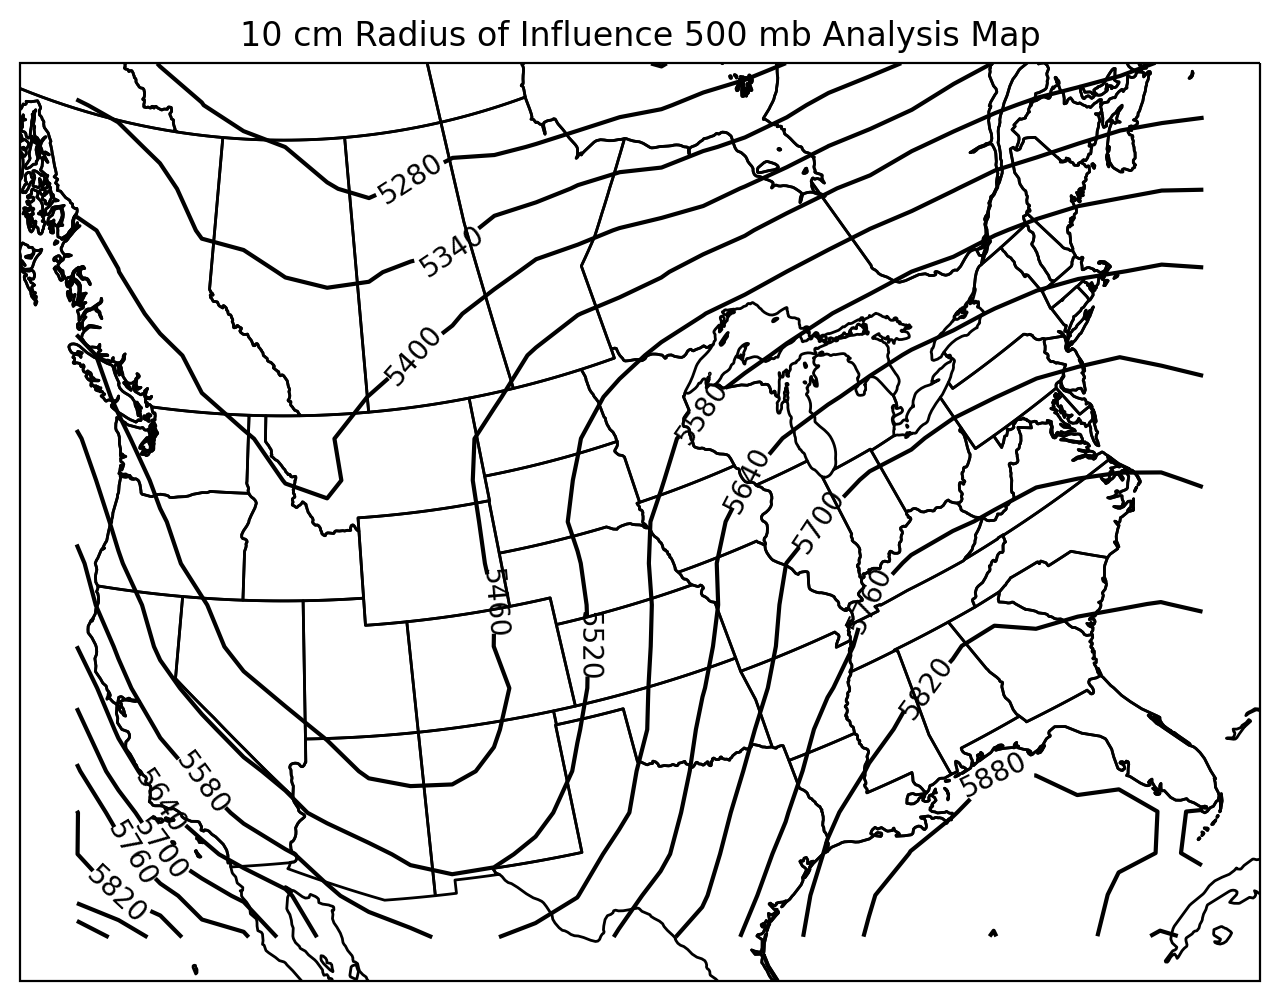

In [288]:
### Plot 500mb analyses over a map ###\
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
plot2 = fig.add_subplot(111,projection=proj)
plot2.add_feature(cfeature.STATES)
plot2.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = plot2.contour(gridlon,gridlat,analysis[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('10 cm Radius of Influence 500 mb Analysis Map')
plt.show()

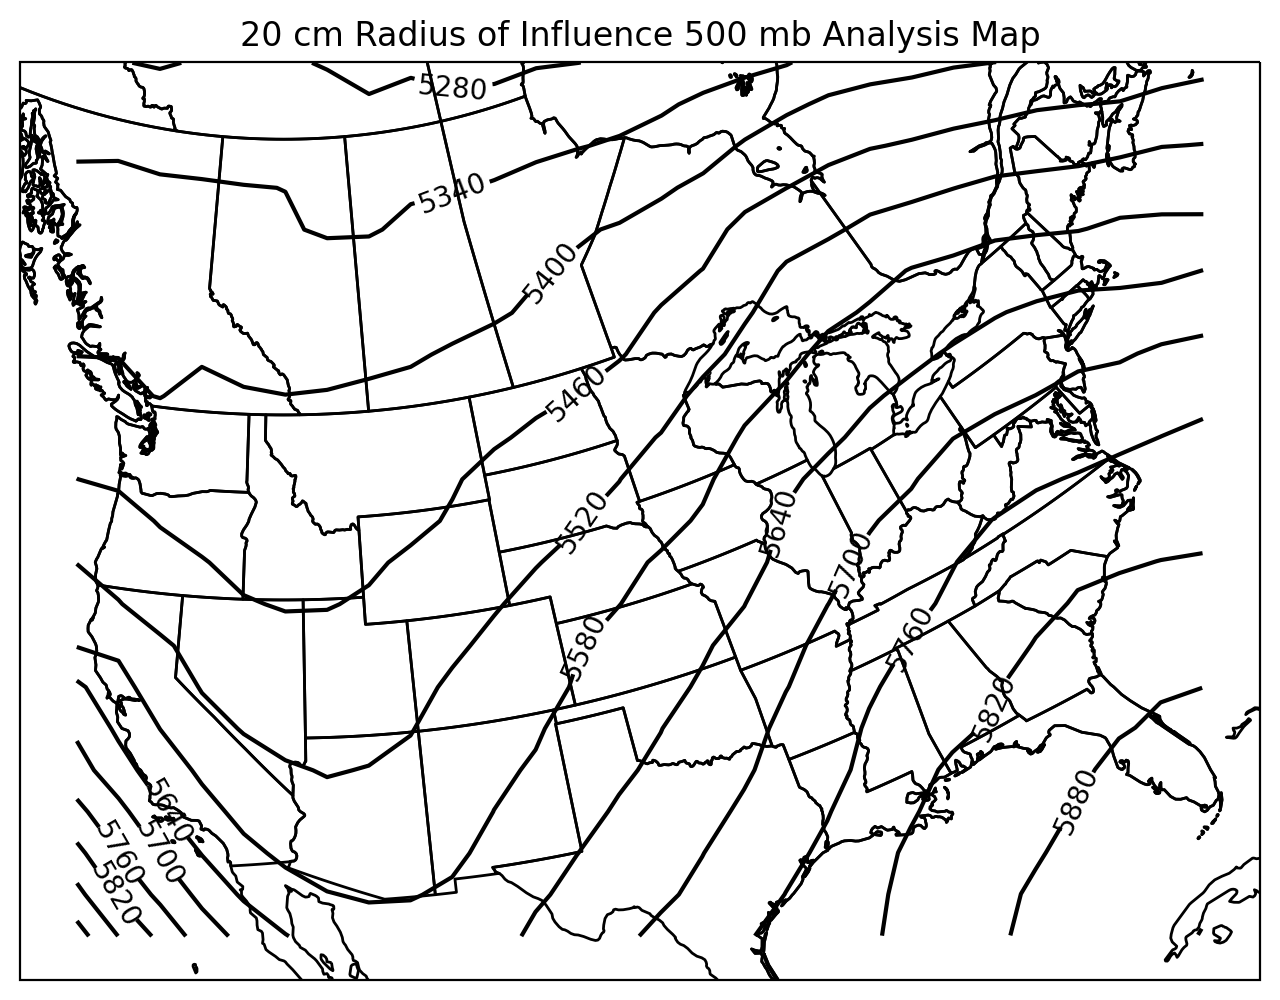

In [289]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
plot3 = fig.add_subplot(111,projection=proj)
plot3.add_feature(cfeature.STATES)
plot3.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = plot3.contour(gridlon,gridlat,analysis[:,:,1],colors='black',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60)) 
plt.title("20 cm Radius of Influence 500 mb Analysis Map")
plt.show()

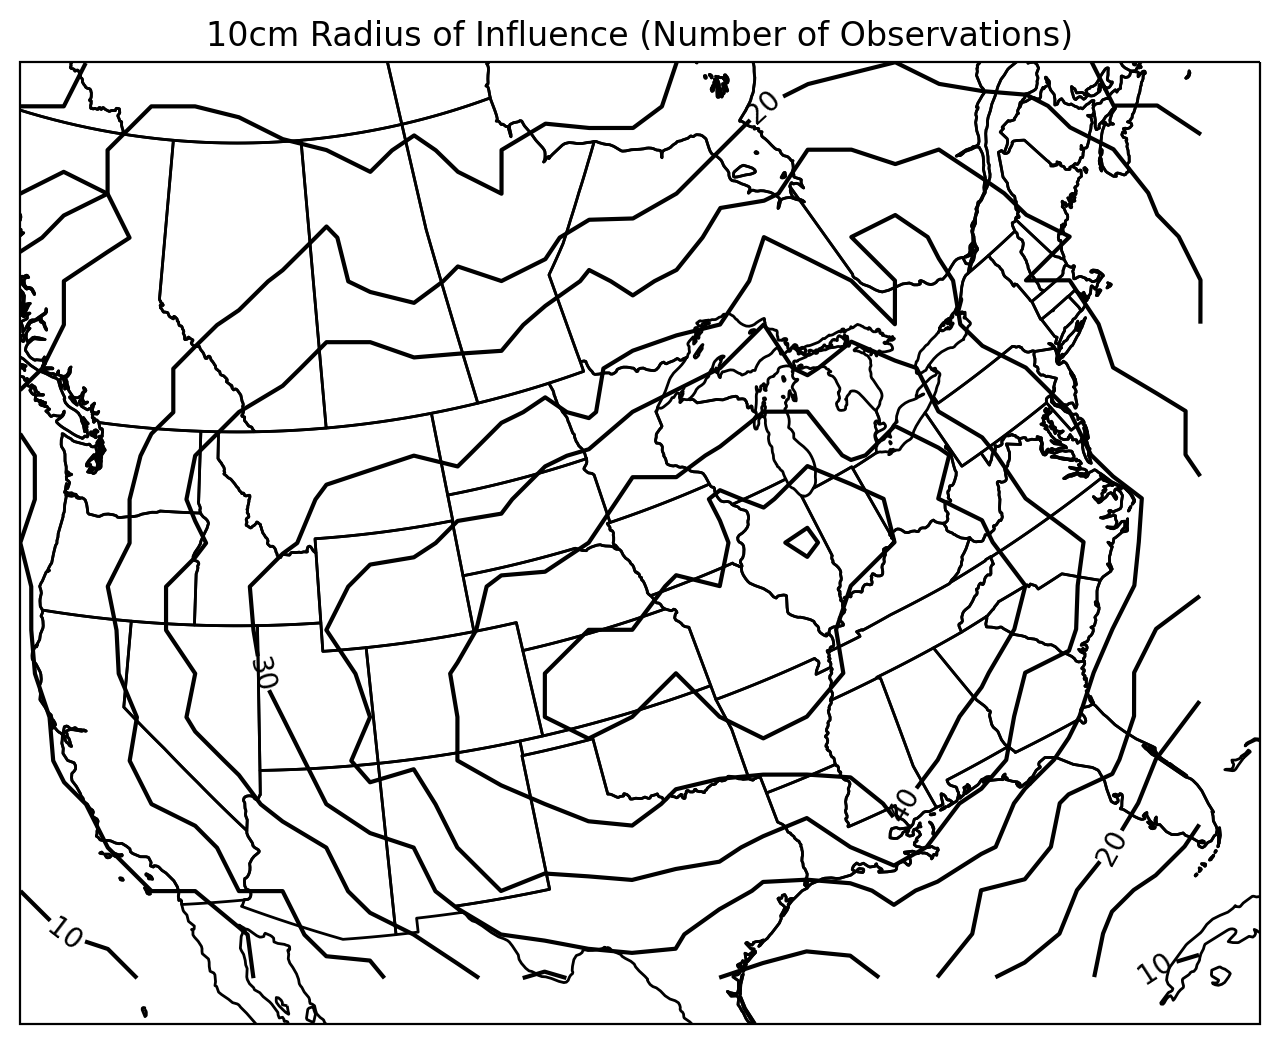

In [291]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
plot4 = fig.add_subplot(111,projection=proj)
plot4.add_feature(cfeature.STATES)
plot4.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = plot4.contour(gridlon,gridlat,n_obs[:,:,0],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.title('10cm Radius of Influence (Number of Observations)')
plt.show()


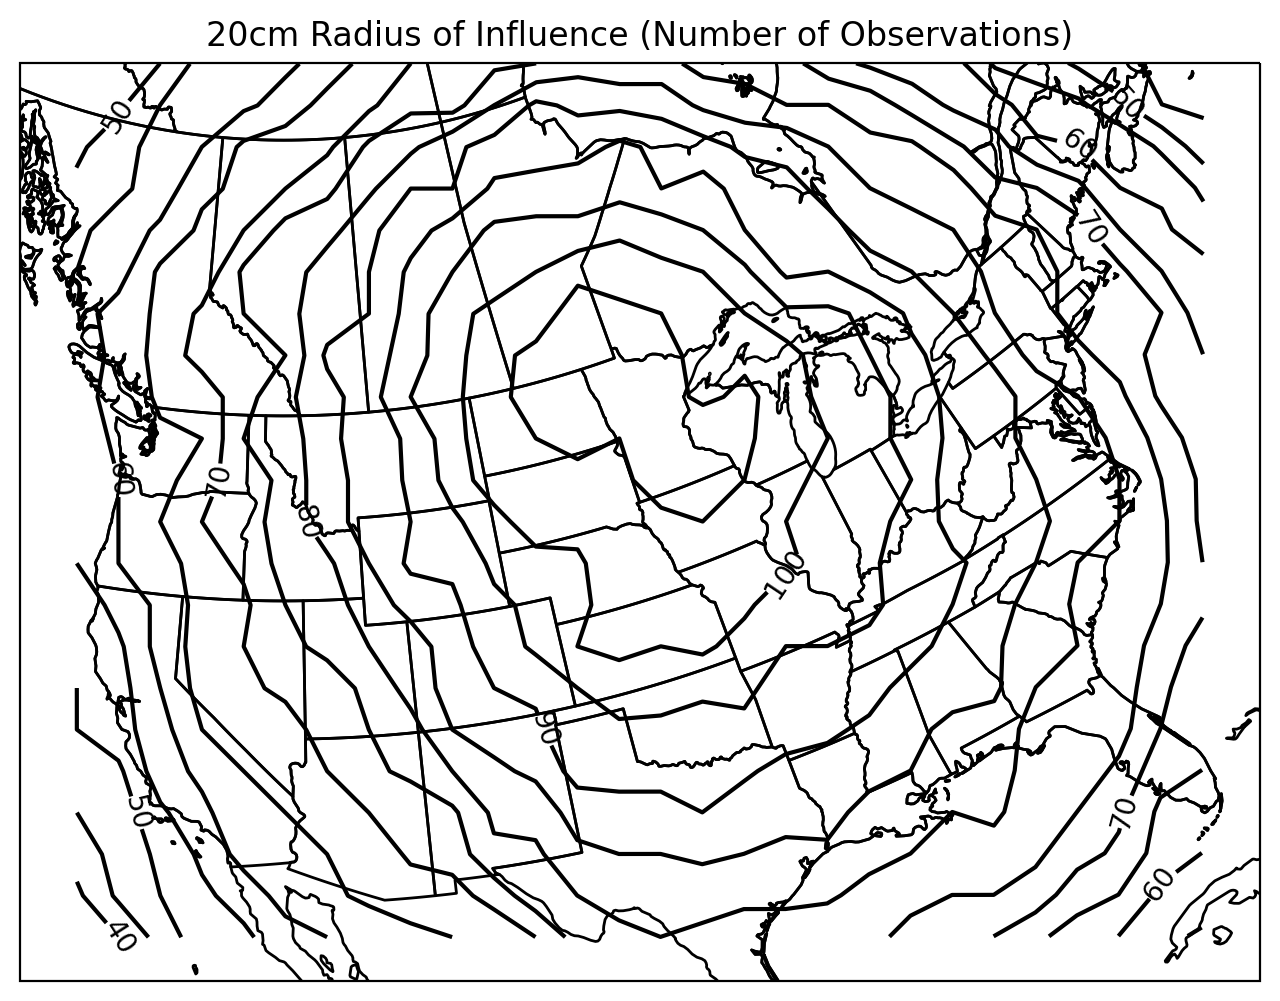

In [292]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
plot5 = fig.add_subplot(111,projection=proj)
plot5.add_feature(cfeature.STATES)
plot5.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = plot5.contour(gridlon,gridlat,n_obs[:,:,1],colors='black',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.title('20cm Radius of Influence (Number of Observations)')
plt.show()

In [293]:
### Store the analyses in text files ###
for i in range(len(gx)):
    for j in range(len(gx[0])):
        grid_point = str([i,j])
        analysis_10 = str(analysis[i,j,0]) 
        analysis_20 = str(analysis[i,j,1])
        out = grid_point + ',' + analysis_10 + ',' + analysis_20 + '\n'
        with open('Analysis_Schlief.txt', 'a+') as f:
            f.write(out) #close file
            #print(out)


In [294]:
### Store the number of observations available for each grid point in text files ###
for i in range(len(gx)):
    for j in range(len(gx[0])):
        grid_point = str([i,j]) 
        n_obs_10 = str(n_obs[i,j,0])
        n_obs_20 = str(n_obs[i,j,1]) 
        out = grid_point + ',' + n_obs_10 + ',' + n_obs_20 + '\n'
        with open('Numberofobs_Schlief.txt', 'a+') as f:
            f.write(out) #close File
            #print(out)


In [166]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    In the height contoured analysis, there is a trough over the Rockies and a ridge located over the Eastern half of the United States. 
    The second contoured analysis shows these features as well but both features are more shallow and smoothed out compared to the 10 sm radius of curvature plot 

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    Most noticeably the 20 cm radius of curvature plots are more smooth and have a less pronounced trough than the 10 cm radius of curvature plot. This difference has to do with the varying the radius of influence suggestions. The 10 cm plot has smaller radius of curvature allowing for "sharper" curves in the contoured analysis. 

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
    
    Running the program with an ROI of 6 cm did not work and actually messed up my plots so I had to track back to fix them. With that said I would assume that the results would not look realistic.  

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    
    You would not be able to complete the matrix inversoin because if the Radius of influence is too small then the determinant of that matrix would be zero which then means that the matrix is not invertible. 

'''

'\n1 - Describe the general features that you see in your contoured analyses.\n    In the height contoured analysis, there is a trough over the Rockies and a ridge located over the Eastern half of the United States. \n    The second contoured anaylus shows these features as well but both features are more shallow and smoothed out compared to the 10 sm radius of curvature plot \n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    \n\n3 - Run your program using a radius of influence of 6 cm (do not need to show).  \n    Describe the results - do they look realistic?  If there are problems, what\n    do you think might be causing them?\n    \n\n4 - Suppose you ran this program with a small enough radius of influence that only one\n    observation was available for determining a polynomial fit at a grid point.  Should\n    you be able to perform the matrix inversion?  Why or